In [ ]:
#pip install mediapipe opencv-python math numpy

In [16]:
############################################################
# IMPORT REQUIRED MODULES
############################################################


import cv2
import mediapipe as mp
import numpy as np
import math
import time
import matplotlib.pyplot as plt
import pandas as pd
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose


In [17]:
############################################################
# DEFINE FUNCTIONS
############################################################
# Not all of these functions are used at the moment

#FROM YOUTUBE TUTORIAL (WORKS BETTER)
def calculate_angle(a,b,c):
    a = np.array(a) #First
    b = np.array(b) #Mid
    c = np.array(c) #End

    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)

    if angle > 180.0:
        angle = 360 - angle

    return angle 

#FROM MR.POSE
def angle(point1, point2, point3):
    if (point1==(0,0) or point2==(0,0) or point3==(0,0)):
        return 0
    
    numerator = point2[1] * (point1[0] - point3[0]) + point1[1] * \
                (point3[0] - point2[0]) + point3[1] * (point2[0] - point1[0])
    denominator = (point2[0] - point1[0]) * (point1[0] - point3[0]) + \
                (point2[1] - point1[1]) * (point1[1] - point3[1])
    try:
        ang = math.atan(numerator/denominator)
        ang = ang * 180 / math.pi
        if ang < 0:
            ang = 180 + ang
        return ang
    except:
        return 90.0


def angle_of_singleline(point1, point2):
    """ Calculate angle of a single line """
    x_diff = point2[0] - point1[0]
    y_diff = point2[1] - point1[1]
    return math.degrees(math.atan2(y_diff, x_diff))


def dist_xy(point1, point2):
    """ Euclidean distance between two points point1, point2 """
    diff_point1 = (point1[0] - point2[0]) ** 2
    diff_point2 = (point1[1] - point2[1]) ** 2
    return (diff_point1 + diff_point2) ** 0.5


def point_position(point, line_pt_1, line_pt_2):
    """
    Left or Right position of the point from a line
    """
    value = (line_pt_2[0] - line_pt_1[0]) * (point[1] - line_pt_1[1]) - \
                (line_pt_2[1] - line_pt_1[1]) * (point[0] - line_pt_1[0])
    if value >= 0:
        return "left"
    return "right"
#########################################################################
# END FUNCTION DEFINITION
#########################################################################


### WARRIOR 2 POSE

Source Info: https://bleedai.com/introduction-to-pose-detection-and-basic-pose-classification/
SOME METRICS: Arms are horizontal: ~ 20 degrees from horizontal. Elbow angles ~ 180, 
Posture orientation:
Left side : left leg bended: (90 degree left kenee, 90 degree left hip angle, vertical lower leg), right leg extended: 180~ angle at knee, ~ 135 angle at hip
Right side : opposite
One leg bended

In [18]:
# USES MEDIAPIPE LANDMARKS TO CALCULATE ANGLES

def get_pose_landmarks(landmarks):
    # GET COORDINATES OF JOINTS
    left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
    left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
    left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

    left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
    left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
    left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

    right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
    right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
    right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

    right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
    right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
    right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]

      # CALCULATE SOME REQUIRED METRICS ANGLES

    left_elbow_angle = np.round(calculate_angle(left_shoulder,left_elbow,left_wrist))
    left_elbow_angle_hor = np.round(angle_of_singleline(left_elbow,left_wrist))
    left_knee_angle = np.round(calculate_angle(left_hip, left_knee, left_ankle))
    left_knee_angle_ver = np.round(angle_of_singleline(left_knee,left_ankle))
    left_hip_angle = np.round(calculate_angle(left_shoulder,left_hip, left_knee))

    right_elbow_angle = np.round(calculate_angle(right_shoulder,right_elbow,right_wrist))
    right_elbow_angle_hor = np.round(angle_of_singleline(right_wrist,right_elbow))
    right_knee_angle = np.round(calculate_angle(right_hip, right_knee, right_ankle))
    right_knee_angle_ver = np.round(angle_of_singleline(right_knee,right_ankle))
    right_hip_angle = np.round(calculate_angle(right_shoulder,right_hip, right_knee))

    return left_elbow_angle, left_elbow_angle_hor, left_knee_angle, left_knee_angle_ver, left_hip_angle, right_elbow_angle, right_elbow_angle_hor, right_knee_angle, right_knee_angle_ver, right_hip_angle
    

In [26]:



#########################################################################
# MAIN BLOCK OF CODE
#########################################################################
file_or_webcam = 0 
# FOR FILE = 0 FOR WEBCAM = 1

video_path = "videos\warrior.mp4"
video_path = "videos\warrior2_test1.mp4"

if file_or_webcam == 0:
   # LOAD VIDEO FROM FILE
   cap = cv2.VideoCapture(video_path) # VIDEO PATH
elif file_or_webcam == 1:
   # START VIDEO CAPTURE FOR LIVE FEED
   cap = cv2.VideoCapture(0) # LIVE FEED

width  = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   # float `width`
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)  # float `height`

left_arm_angle_list = []
right_arm_angle_list = []
left_knee_angle_list = []
left_knee_ver_list = []
right_knee_angle_list = []
right_knee_ver_list =[]

pose_list = []


with mp_pose.Pose(min_detection_confidence=0.5,min_tracking_confidence=0.5) as pose:
  while cap.isOpened():
    ret, frame = cap.read()

    # Recolor image
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    image.flags.writeable = False
    # Make detection
    results = pose.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #cv2.namedWindow("Mediapipe Feed", cv2.WINDOW_NORMAL)
    #cv2.setWindowProperty("Mediapipe Feed", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

    #DEFINE INITIAL VARIABLES FOR POSTURE DETECTION MESSAGES AND COLORS
    pose_orientation = "WAITING..."
    pose_color = (0,0,0)
    left_arm_correct = "WAITING..."
    right_arm_correct = "WAITING..."
    right_color_rec = (0,0,0)
    left_color_rec = (0,0,0)
    leg_correction = "WAITING..."
    leg_color_rec = (0,0,0)
    leg_correction_angle = "WAITING..."
    leg_ang_color_rec = (0,0,0)
    
    try:

      # EXTRACT MEDIAPIPE LANDMARKS
      landmarks = results.pose_landmarks.landmark
      
      # GET COORDINATES OF JOINTS
      left_shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
      left_elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
      left_wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]

      left_hip = [landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].x,landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y]
      left_knee = [landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value].y]
      left_ankle = [landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value].y]

      right_shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
      right_elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
      right_wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

      right_hip = [landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value].y]
      right_knee = [landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value].y]
      right_ankle = [landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].x,landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value].y]


      # CALCULATE SOME REQUIRED METRICS ANGLES
      # ANGLE FROM HORIZONTALS ARE POSITIVE CLOCKWISE, SO REQUIRES MINOR ADJUST TO BE CONSISTENT

      left_elbow_angle = np.round(calculate_angle(left_shoulder,left_elbow,left_wrist)).astype(int)
      #left_elbow_angle_hor = np.round(angle_of_singleline(left_elbow,left_wrist)).astype(int)
      left_elbow_angle_hor = np.round(-angle_of_singleline(left_elbow,left_wrist)).astype(int) #sign change to be consistent
      left_knee_angle = np.round(calculate_angle(left_hip, left_knee, left_ankle)).astype(int)
      left_knee_angle_ver = np.round(angle_of_singleline(left_knee,left_ankle)).astype(int)
      left_hip_angle = np.round(calculate_angle(left_shoulder,left_hip, left_knee)).astype(int)

      right_elbow_angle = np.round(calculate_angle(right_shoulder,right_elbow,right_wrist)).astype(int)
      right_elbow_angle_hor = np.round(angle_of_singleline(right_wrist,right_elbow)).astype(int)
      right_knee_angle = np.round(calculate_angle(right_hip, right_knee, right_ankle)).astype(int)
      right_knee_angle_ver = np.round(180-angle_of_singleline(right_knee,right_ankle)).astype(int)
      #right_knee_angle_ver = np.round(angle_of_singleline(right_knee, right_ankle)).astype(int) # gives angle from hotirontal "clockwise"
      right_hip_angle = np.round(calculate_angle(right_shoulder,right_hip, right_knee)).astype(int)
      

      
    
      
      # VISUALIZE LANDMARSK
      # LEFT ARM
      cv2.putText(image, str(left_elbow_angle),
                  tuple(np.multiply(left_elbow,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      cv2.putText(image, "HOR: " + str(left_elbow_angle_hor),
                  tuple(np.multiply(left_wrist,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      
      # RIGHT ARM
      cv2.putText(image, str(right_elbow_angle),
                  tuple(np.multiply(right_elbow,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      cv2.putText(image, "HOR: " + str(right_elbow_angle_hor),
                  tuple(np.multiply(right_wrist,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      
      # LEFT KNEE
      cv2.putText(image, str(left_knee_angle),
                  tuple(np.multiply(left_knee,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      cv2.putText(image, "VER: " + str(left_knee_angle_ver),
                  tuple(np.multiply(left_ankle,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      
      # RIGHT KNEE
      cv2.putText(image, str(right_knee_angle),
                  tuple(np.multiply(right_knee,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      cv2.putText(image, "VER: " + str(right_knee_angle_ver),
                  tuple(np.multiply(right_ankle,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      
      # HIPS
      cv2.putText(image, str(left_hip_angle),
                  tuple(np.multiply(left_hip,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      cv2.putText(image, str(right_hip_angle),
                  tuple(np.multiply(right_hip,[width, height]).astype(int)),
                  cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,0,0),2, cv2.LINE_AA
                  )
      
      


      # POSTURE CORRECTION BLOCK
      
      # FIRST, DETECT POSTURE ORIENTATION: RIGHT OR LEFT
      # WARRIOR 2 IS AN ASYMMETRIC POSTURE, SO FIRST WE TRY TO DETECT ORIENTATION
      # CHECK THREE INDICATORS:
      #1: back leg is extended with angle between hip-knee-angle ~ 180 (range 150 - 210)
      #2: front leg is bended with angle between hip-knee-angle ~ 90 (range 70-150)
      #3: arms are extended and horizontal, angle with horizontal within 45 degrees (-45 to 45)

      if ((left_knee_angle > 150 and left_knee_angle < 210)) and ((right_knee_angle > 70 and right_knee_angle < 150) and (left_knee_angle_ver<75)) and (right_elbow_angle_hor < 45 and right_elbow_angle_hor > -45) and  (left_elbow_angle_hor < 45 and left_elbow_angle_hor > -45):
        pose_orientation = "RIGHT WARRIOR 2"
        pose_color = (0,255,0) # GREEN COLOR
      elif ((right_knee_angle > 150 and right_knee_angle < 210)) and ((left_knee_angle > 70 and left_knee_angle < 150) and (right_knee_angle_ver<75)) and (right_elbow_angle_hor < 45 and right_elbow_angle_hor > -45) and  (left_elbow_angle_hor < 45 and left_elbow_angle_hor > -45):
        pose_orientation = "LEFT WARRIOR 2"
        pose_color = (0,255,0) # GREEN COLOR
      else:
        pose_orientation = "UNKNOWN"
        pose_color = (0,0,0)


      

      # BOTH ARMS SHOULD BE EXTENDED (WITH ANGLE AT ELBOW ~ 180 DEGREES)
      # BOTH ARMS SHOULD BE HORIZONTAL (WITH ANGLE FROM HORIZONTAL ~ 0)


      if (pose_orientation == "LEFT WARRIOR 2") or (pose_orientation == "RIGHT WARRIOR 2"):
      # CORRECTIONS LEFT ARM
        if left_elbow_angle_hor > 20:
          left_arm_correct = "LEFT ARM TOO HIGH"
          left_color_rec = (255,0,0)
        elif left_elbow_angle_hor < -20:
          left_arm_correct = "LEFT ARM TOO LOW"
          left_color_rec = (255,0,0)
        elif left_elbow_angle_hor <= 20 and left_elbow_angle_hor >= -20:
          left_arm_correct = "GOOD"
          left_color_rec = (0,255,0) # GREEN COLOR
      #CORRECTIONS RIGHT ARM
        if right_elbow_angle_hor > 20:
          right_arm_correct = "RIGHT ARM TOO HIGH"
          right_color_rec = (255,0,0)
        elif right_elbow_angle_hor < -20:
          right_arm_correct = "RIGHT ARM TOO LOW"
          right_color_rec = (255,0,0)
        elif right_elbow_angle_hor <= 20 and right_elbow_angle_hor >= -20:
          right_arm_correct = "GOOD"
          right_color_rec = (0,255,0)  # GREEN COLOR
      #else:
      #  left_arm_correct = "WAITING"
      #  left_arm_correct = "WAITING"
        
      #CORRECTIONS LEGS AND HIPS
      #BENDED LEG: FORELEG ANGLE SHOULD BE VERTICAL, WITH ~90 DEEGREE FROM FLOOR
      #BENDED LEG: ANGLE BETWEEN FORELEG AND TIGHT SHOULD BE ~ 90 DEGREES
      #FLEXED LEG: ANGLE BETWEEN FORELEG AND TIGHT SHOULD BE ~180 DEGREES
      #FLEXED LEG: ANGLE BETWEEN CORE AND TIGHT AT HIP SHOULD BE ~ 135 DEGREES


      if pose_orientation == "RIGHT WARRIOR 2":
        if right_knee_angle_ver > 110 or right_knee_angle_ver < 70:
          leg_correction = "FORELEG SHOULD BE CLOSER TO VERTICAL"
          leg_color_rec = (255,0,0)
        elif right_knee_angle_ver <= 110 and right_knee_angle_ver >= 70:
          leg_correction = "GOOD"
          leg_color_rec = (0,255,0)
        if right_knee_angle > 140 or right_knee_angle < 60:
          leg_correction_angle = "FORELEG-THIGHT ANGLE SHOULD BE ~115"
          leg_ang_color_rec = (255,0,0)
        elif right_knee_angle <= 140 and right_knee_angle >= 60:
          leg_correction_angle = "GOOD"
          leg_ang_color_rec = (0,255,0)
      
      if pose_orientation == "LEFT WARRIOR 2":
        if left_knee_angle_ver > 110 or left_knee_angle_ver < 70:
          leg_correction = "FORELEG SHOULD BE CLOSER TO VERTICAL"
          leg_color_rec = (255,0,0)
        elif left_knee_angle_ver <= 110 and left_knee_angle_ver >= 70:
          leg_correction = "GOOD"
          leg_color_rec = (0,255,0)
        if left_knee_angle > 140 or left_knee_angle < 60:
          leg_correction_angle = "FORELEG-THIGHT ANGLE SHOULD BE ~115"
          leg_ang_color_rec = (255,0,0)
        elif left_knee_angle <= 140 and left_knee_angle >= 60:
          leg_correction_angle = "GOOD"
          leg_ang_color_rec = (0,255,0)


      #print(landmarks)
    except:
      pass
    

    #print(pose_orientation)
    left_arm_angle_list.append((left_elbow_angle_hor))
    right_arm_angle_list.append((right_elbow_angle_hor))

    left_knee_angle_list.append(left_knee_angle)
    left_knee_ver_list.append(left_knee_angle_ver)
    right_knee_angle_list.append(right_knee_angle)
    right_knee_ver_list.append(right_knee_angle_ver)


    pose_list.append(pose_orientation)


    #ARM CORRECTIONS MESSAGES
    cv2.putText(image, "HINT ARMS:", (10,20),
                cv2.FONT_HERSHEY_SIMPLEX,0.75,(0,0,0),2,cv2.LINE_AA)
    cv2.putText(image, left_arm_correct, (10,60),
                cv2.FONT_HERSHEY_SIMPLEX,0.75, left_color_rec,2,cv2.LINE_AA)
    cv2.putText(image, right_arm_correct, (10,100),
                cv2.FONT_HERSHEY_SIMPLEX,0.75, right_color_rec,2,cv2.LINE_AA)
    #LEG CORRECTIONS MESSAGES
    cv2.putText(image, "HINT FRONT LEG:", (10,200),
                cv2.FONT_HERSHEY_SIMPLEX,0.75,(0,0,0),2,cv2.LINE_AA)
    cv2.putText(image, leg_correction, (10,240),
                cv2.FONT_HERSHEY_SIMPLEX,0.75, leg_color_rec,2,cv2.LINE_AA)
    cv2.putText(image, leg_correction_angle, (10,280),
                cv2.FONT_HERSHEY_SIMPLEX,0.75, leg_ang_color_rec,2,cv2.LINE_AA)
  
  

    #POSE DETECTION
    cv2.putText(image, "POSE:", (350,20),
                cv2.FONT_HERSHEY_SIMPLEX,0.75,(0,0,0),2,cv2.LINE_AA)
    cv2.putText(image, pose_orientation, (350,60),
                cv2.FONT_HERSHEY_SIMPLEX,0.75,pose_color,2,cv2.LINE_AA)
    
    #Setup Orientation box

    # Render detections
    mp_drawing.draw_landmarks(image, results.pose_landmarks,mp_pose.POSE_CONNECTIONS,
                              mp_drawing.DrawingSpec(color=(245,117,66),thickness=2, circle_radius=2),
                              mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2)
                              )


    #print(results)


  
    cv2.imshow("Mediapipe Feed", image)

    if cv2.waitKey(10) & 0xFF == ord("q"):
      break

  cap.release()
  cv2.destroyAllWindows()

In [27]:

df_pose = pd.DataFrame(pose_list, columns=["Pose"])
df=pd.concat([df_pose, pd.Series(left_arm_angle_list), pd.Series(right_arm_angle_list), pd.Series(left_knee_angle_list),pd.Series(right_knee_angle_list), pd.Series(left_knee_ver_list),pd.Series(right_knee_ver_list)],axis=1).rename(columns={0:"left arm", 1:"right arm", 2:"left knee ang", 3:"right knee ang", 4:"left knee ver",5:"right knee ver"})
df["Pose Code"] = pd.Categorical(df["Pose"],ordered=True, categories=["UNKNOWN", "LEFT WARRIOR 2", "RIGHT WARRIOR 2"]).codes

#df.head()



In [28]:
filt_pose1 = df["Pose Code"] == 1
filt_pose2 = df["Pose Code"] == 2

In [29]:
df[filt_pose1]

,Pose,left arm,right arm,left knee ang,right knee ang,left knee ver,right knee ver,Pose Code


posx and posy should be finite values
posx and posy should be finite values


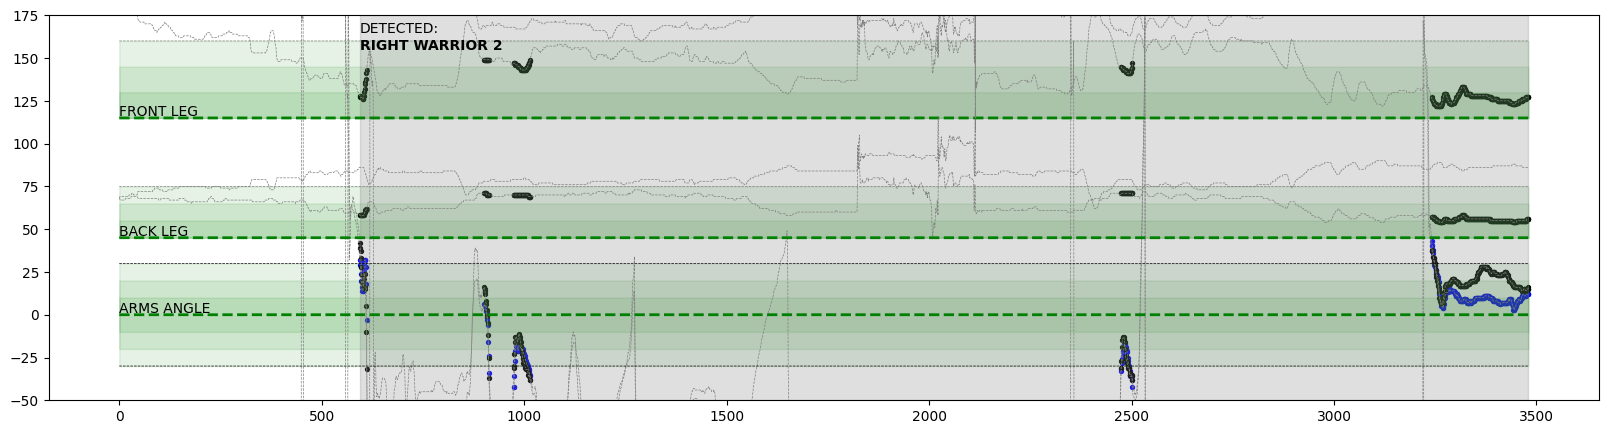

In [30]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

expected_arm_angle = 0
range = 30

plt.plot(df.index, df["left arm"], color="gray",  linestyle='dashed', label='FirstTrial', linewidth=0.50)
plt.plot(df.index, df["right arm"], color="gray",  linestyle='dashed',  label='FirstTrial', linewidth=0.50)
plt.plot(df.index, df.index*expected_arm_angle, color="green",  linestyle='dashed', label='FirstTrial', linewidth=2)
plt.plot(df.index, df.index*0+range,color="black",  linestyle='dashed',linewidth=0.50)
plt.plot(df.index, df.index*0-range, color="black",  linestyle='dashed',linewidth=0.50)

plt.scatter(df[filt_pose1].index, df["left arm"][filt_pose1], 8, color="blue")
plt.scatter(df[filt_pose1].index, df["right arm"][filt_pose1],8, color="black")

plt.scatter(df[filt_pose2].index, df["left arm"][filt_pose2],8,color="blue")
plt.scatter(df[filt_pose2].index, df["right arm"][filt_pose2],8, color="black")

plt.fill_between(df.index, expected_arm_angle-range, expected_arm_angle+range, alpha=0.10, color="green")
plt.fill_between(df.index, expected_arm_angle-range*2/3, expected_arm_angle+range*2/3, alpha=0.10, color="green")
plt.fill_between(df.index, expected_arm_angle-range*1/3, expected_arm_angle+range*1/3, alpha=0.10, color="green")

#FRONT LEG ANGLE

front_leg_ang_expect = 115
front_leg_ang_expect_range = 45  # Detection limit

plt.plot(df.index, df["left knee ang"], color="gray",  linestyle='dashed', linewidth=0.50)
plt.plot(df.index, df["right knee ang"], color="gray",  linestyle='dashed', linewidth=0.50)
plt.plot(df.index, df.index*0+front_leg_ang_expect, color="green",  linestyle='dashed', linewidth=2)
plt.plot(df.index, df.index*0+front_leg_ang_expect+front_leg_ang_expect_range, color="gray",  linestyle='dashed', linewidth=0.5)


# FRONT LEG LEFT WARRIOR
plt.scatter(df[filt_pose1].index, df["left knee ang"][filt_pose1],8, color="black")


# FRONT LEG RIGHT WARRIOR
plt.scatter(df[filt_pose2].index, df["right knee ang"][filt_pose2],8, color="black")

plt.fill_between(df.index, front_leg_ang_expect, front_leg_ang_expect+front_leg_ang_expect_range, alpha=0.10, color="green")
plt.fill_between(df.index, front_leg_ang_expect, front_leg_ang_expect+front_leg_ang_expect_range*2/3, alpha=0.10, color="green")
plt.fill_between(df.index, front_leg_ang_expect, front_leg_ang_expect+front_leg_ang_expect_range*1/3, alpha=0.10, color="green")

back_leg_ver_expect = 45
back_leg_ver_expect_range = 30 #detection limit

plt.plot(df.index, df["left knee ver"], color="gray",  linestyle='dashed', linewidth=0.5)
plt.plot(df.index, df["right knee ver"], color="gray",  linestyle='dashed',  linewidth=0.5)
plt.plot(df.index, df.index*0+ back_leg_ver_expect , color="green",  linestyle='dashed',  label='Front Leg Bend = 90', linewidth=2)
plt.plot(df.index, df.index*0+ back_leg_ver_expect + back_leg_ver_expect_range, color="gray",  linestyle='dashed',  label='FirstTrial', linewidth=0.5)

# BACK LEG LEFT WARRIOR
plt.scatter(df[filt_pose1].index, df["right knee ver"][filt_pose1],8, color="black")

# BACK LEG LEFT WARRIOR
plt.scatter(df[filt_pose2].index, df["left knee ver"][filt_pose2],8,color="black")



plt.fill_between(df.index, back_leg_ver_expect, back_leg_ver_expect+back_leg_ver_expect_range, alpha=0.10, color="green")
plt.fill_between(df.index, back_leg_ver_expect, back_leg_ver_expect+(back_leg_ver_expect_range)*2/3, alpha=0.10, color="green")
plt.fill_between(df.index, back_leg_ver_expect, back_leg_ver_expect+(back_leg_ver_expect_range)*1/3, alpha=0.10, color="green")

try:
    plt.axvspan(df[filt_pose1].index.min(), df[filt_pose1].index.max() , color='gray', alpha=0.25)
    plt.text(df[filt_pose1].index.min(),165,"DETECTED:")
    plt.text(df[filt_pose1].index.min(),155,df[filt_pose1]["Pose"].iloc[0],fontweight='bold')
except:
    pass
try:
    plt.axvspan(df[filt_pose2].index.min(), df[filt_pose2].index.max() , color='gray', alpha=0.25)
    plt.text(df[filt_pose2].index.min(),165,"DETECTED:")
    plt.text(df[filt_pose2].index.min(),155,df[filt_pose2]["Pose"].iloc[0],fontweight='bold')
except:
    pass
    #plt.text(0,0,"NO POSE DETECTED")

plt.text(0,expected_arm_angle+1,"ARMS ANGLE", fontsize=10)
plt.text(0,front_leg_ang_expect+1,"FRONT LEG",fontsize=10)
plt.text(0,back_leg_ver_expect+1,"BACK LEG",fontsize=10)

plt.ylim(-50,175)
plt.show()

In [11]:
df[filt_pose2]

,Pose,left arm,right arm,left knee ang,right knee ang,left knee ver,right knee ver,Pose Code
313,RIGHT WARRIOR 2,32,41,177,123,58,89,2
314,RIGHT WARRIOR 2,31,39,177,123,58,89,2
315,RIGHT WARRIOR 2,30,37,177,123,58,89,2
316,RIGHT WARRIOR 2,30,36,177,123,58,89,2
317,RIGHT WARRIOR 2,29,34,177,123,58,89,2
...,...,...,...,...,...,...,...,...
471,RIGHT WARRIOR 2,2,14,176,123,59,90,2
472,RIGHT WARRIOR 2,2,14,176,123,59,90,2
473,RIGHT WARRIOR 2,2,14,176,123,59,90,2
474,RIGHT WARRIOR 2,2,14,176,123,59,90,2


In [264]:
df[filt_pose1].index.min()

nan